* 
* Mache tsne um Spektra in Drift-Klassen einzuteilen
* Trainiere alle Daten so, dass sie die gleiche Drift-Klasse haben (continuous training: erst Klasse 2 auf Klasse 1, dann Klasse 3 auf Klasse 1, dann Klasse 4 auf Klasse 1). 
* Dafür Loss function engineeren, eine silent region aus Klasse 1 als Ziel
* Silent region zwischen x=1750 und x=1800, x-werte bei vec von preprocessing_comparison (rausschneiden und dann tsne)


**I am doing the PCA on two datasets, because I am not sure which one I am supposed to use**

## Data from LuCa vs. NSR

Loading the data with the code provided from Kosmas

In [1]:
import pandas as pd
import numpy as np

path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

vec.head()

###---###---###  Import  ###---###---###
import pandas as pd
import os.path 
import json

path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

cancer = df[df.cancer_status==1]
healthy = df[df.cancer_status==0]
list_Healthy = healthy.filename  
list_Cancer = cancer.filename

df_Healthy = pd.DataFrame()
for name in list_Healthy:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Healthy = pd.DataFrame(data).T
        frame_Healthy['filename'] = os.path.basename(json_file)
        df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)

df_Cancer = pd.DataFrame()
for name in list_Cancer:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Cancer = pd.DataFrame(data).T
        frame_Cancer['filename'] = os.path.basename(json_file)
        df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)

# df_Healthy = pd.DataFrame()
# for name in list_Healthy:
#     csv = os.path.join(path_data, str(name))
#     vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Healthy = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Healthy['filename'] = os.path.basename(csv)
#     df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
#
# df_Cancer = pd.DataFrame()
# for name in list_Cancer:
#     csv = os.path.join(path_data, str(name))
#     # vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Cancer = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Cancer['filename'] = os.path.basename(csv)
#     df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)


df_Healthy = df_Healthy.set_index('filename')
df_Cancer = df_Cancer.set_index('filename')
df_Cancer['Label'] = 1
df_Healthy['Label'] = 0

df_FTIR = df_Healthy.append(df_Cancer)
y_data = df_FTIR[['Label']].values.T[0]
df_FTIR = df_FTIR.drop(['Label'], axis=1)

df_FTIR.columns = vec_
df_FTIR = df_FTIR.T
df_FTIR = df_FTIR[(df_FTIR.index>1000) & (df_FTIR.index<3000)]
df_FTIR = df_FTIR.T

x_data = df_FTIR.values
vec=df_FTIR.columns

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_13256\2308084120.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_13256\2308084120.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_13256\2308084120.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_13256\2308084120.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Preprocessing the data with the standard method (code provided by Kosmas). Instead of removing the silent region, we remove everything except for this region.

In [210]:
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

###---###---###  Preprocessing  ###---###---###

water = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\20201028 - warer spectrum measured by marinus.txt", sep='\t')
water = water[(water.X>1000) & (water.X<3000)]

res_all = []
ra = np.where((vec>2000) & (vec<2300))
mi = np.min(ra)
ma = np.max(ra)
y = water.Abs

for l in range(x_data.shape[0]):

    k = 0
    res = []
    for i in range(50):
        k = k + 1
        x_wc = x_data[l] + 0.001*k*y[:,None].T
        x_dev = savgol_filter(x_wc, window_length = 9, polyorder=2, deriv=1)
        res.append(np.mean(np.abs(x_dev[0][mi:ma])))
    res_all.append(res)
res_all = np.array(res_all)

weights = np.argmin(res_all,1)*0.001

x_data = x_data + np.outer(weights,y)

            #---#

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

a = np.where(vec==find_nearest(vec,1000))[0][0]
b = np.where(vec==find_nearest(vec,1800))[0][0]+1
c = np.where(vec==find_nearest(vec,2800))[0][0]

vec = np.concatenate((vec[a:b],vec[c:]))
x_data = x_data[:,b:c] #we are interested in the silent region

x_data = normalize(x_data, norm='l2')

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_3040\1631341795.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_wc = x_data[l] + 0.001*k*y[:,None].T


In [211]:
#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
x_data = standardscaler.fit_transform(x_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1046 samples in 0.001s...
[t-SNE] Computed neighbors for 1046 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1046
[t-SNE] Computed conditional probabilities for sample 1046 / 1046
[t-SNE] Mean sigma: 5.753314
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.064552
[t-SNE] KL divergence after 1500 iterations: 0.488917


Text(0.5, 1.0, 'T-SNE')

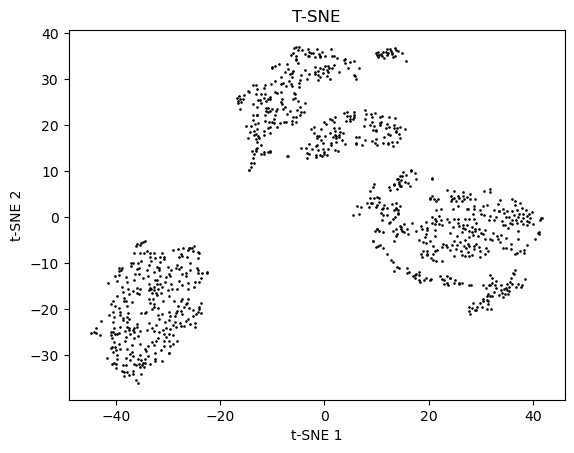

In [212]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1500)
tsne_results = tsne.fit_transform(x_data)

x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]
plt.plot(x_tsne, y_tsne, "ko", markersize = 0.9)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("T-SNE")

## Data that Maik uses

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [242]:
#From Maik
path_data = '//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum/'   # path for json files

path = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/pilot study/pilot study/' # location of cohort metafiles

meta_full = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/L4L_metatags_Serum_20220719.csv'  

metafile_full = pd.read_csv(meta_full, delimiter=';')
metafile_full = metafile_full[['File Name']]
metafile_full = metafile_full.rename(columns={'File Name':'filename'})
metafile_full = metafile_full.drop_duplicates(subset='filename', keep="first")

metafile_0 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_0_matched.xlsx')
metafile_0 = metafile_0[['filename','cancer_status']]

metafile_1 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_1_matched.xlsx')
metafile_1 = metafile_1[['filename','cancer_status']]

metafile_2 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_2_matched.xlsx')
metafile_2 = metafile_2[['filename','cancer_status']]

# Inner merge of complete metafile with individuals to get intersection between them (From Maik)

merged_0 = pd.merge(left=metafile_full, right=metafile_0, how='inner')
merged_1 = pd.merge(left=metafile_full, right=metafile_1, how='inner')
merged_2 = pd.merge(left=metafile_full, right=metafile_2, how='inner')

In [243]:
#Adding Labels to the merged metafiles (for the drifts)
merged_0.insert(2, 'label', list(np.full(merged_0.shape[0], 0)))
merged_1.insert(2, 'label', list(np.full(merged_1.shape[0], 1)))
merged_2.insert(2, 'label', list(np.full(merged_2.shape[0], 2)))
merged_2.head()

,filename,cancer_status,label
0,021606 - 9895829867299,0,2
1,020709 - 9895790801420,0,2
2,033-142 - 4398137359249,1,2
3,020753 - 9895790539247,0,2
4,020541 - 9895789424920,0,2


In [252]:
import numpy as np
import os.path 
import json as js 

metafiles_labels = {0: merged_0,
                    1: merged_1,
                    2: merged_2}

spectra_path = "//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum"

absorbances = []
labels = []

for label, metafile in metafiles_labels.items():
    for i in range(1, len(metafile)):
        #k=0
        ID = metafile["filename"][i] + ".json"
        spectrum_path_id ="%s/%s"%(spectra_path,ID) 
        if os.path.isfile(spectrum_path_id):
            f = open(spectrum_path_id, "r")
            spect = js.loads(f.read(), strict=False)
            ab_data = spect["AB Data"]
            ab_data = list(reversed(ab_data))
            absorbances.append(ab_data)
            labels.append(label)
        else:
            print('no file found')
            
            #k -= 1 #If spectra could not be loaded, there are less spectra for a label
    #l = len(metafile)-k
    #lens.append(l)
   # print(f'Number of spectra for label {label}: {l}')
    
        
absorbances = np.array(absorbances)

(1811, 1101)

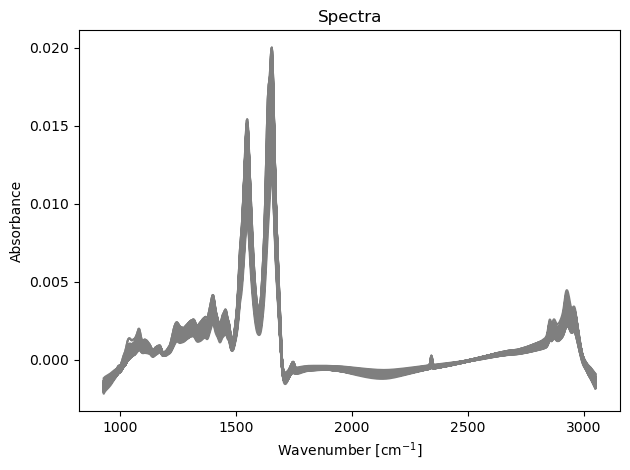

In [253]:
for i in range(len(absorbances)):
    plt.plot(vec_, absorbances[i], color = "tab:gray")
plt.xlabel("Wavenumber [cm$^{-1}$]")
plt.ylabel("Absorbance")

plt.title("Spectra")
plt.plot()
plt.tight_layout()

Now we do a similar preprocessing as with the data above, only that we can't use the water correction (because shapes don't match).

In [254]:
#Savgol filter
absorbances = savgol_filter(absorbances, window_length = 9, polyorder=2, deriv=1)

#normalizing the data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
absorbances = normalizer.fit_transform(absorbances)

#cutting silent region
range_silent = [1800, 2300]


for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i

silent_region = [spect[min_index:max_index] for spect in absorbances]
silent_region = np.array(silent_region)
silent_region.shape


"""
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

a = np.where(vec==find_nearest(vec,1000))[0][0]
b = np.where(vec==find_nearest(vec,range_silent[0]))[0][0]+1
c = np.where(vec==find_nearest(vec,range_silent[1]))[0][0]
"""

'\ndef find_nearest(array, value):\n    array = np.asarray(array)\n    idx = (np.abs(array - value)).argmin()\n    return array[idx]\n\na = np.where(vec==find_nearest(vec,1000))[0][0]\nb = np.where(vec==find_nearest(vec,range_silent[0]))[0][0]+1\nc = np.where(vec==find_nearest(vec,range_silent[1]))[0][0]\n'

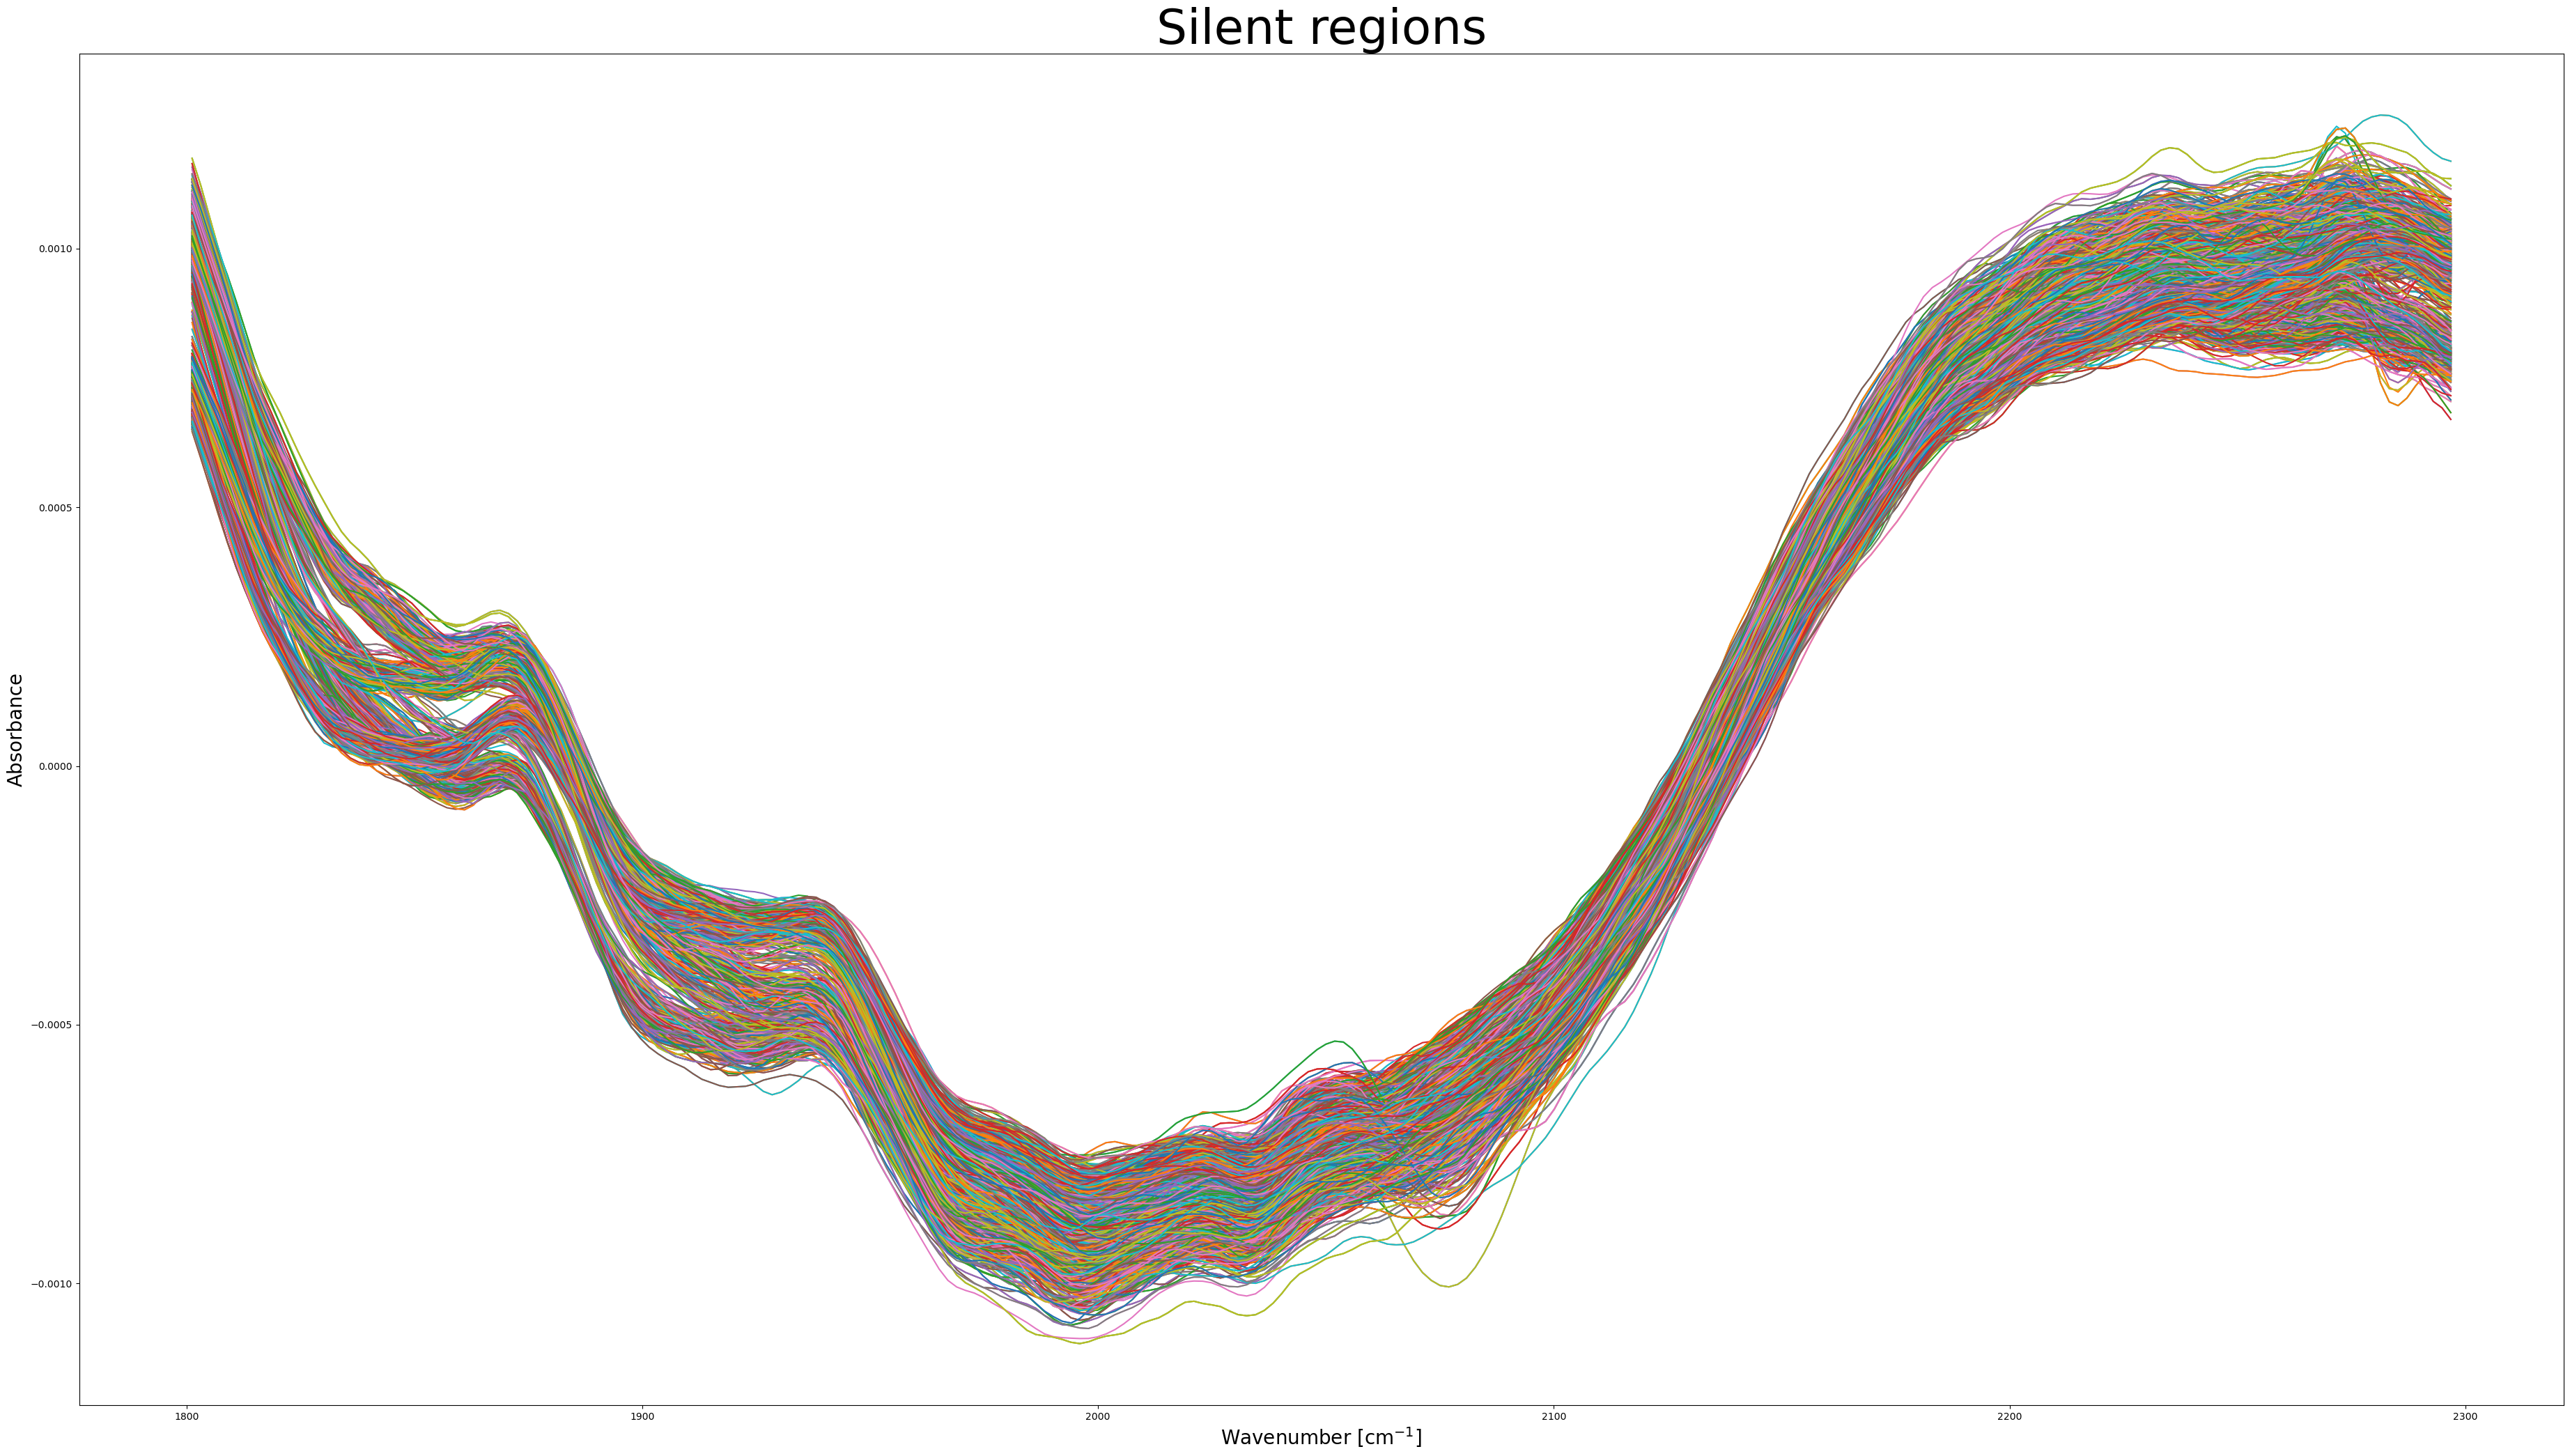

In [255]:
plt.figure(figsize= (18.5 * 2, 10.5 * 2))
for i in range(len(silent_region)):
    plt.plot(vec_[min_index:max_index], silent_region[i])
plt.xlabel("Wavenumber [cm$^{-1}$]",fontsize=20)
plt.ylabel("Absorbance", fontsize=20)
plt.title("Silent regions",fontsize=50)
plt.tight_layout()

In [256]:
#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
silent_region = standardscaler.fit_transform(silent_region)

In [274]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
tsne_results = tsne.fit_transform(silent_region)

x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]

tsne_df = pd.DataFrame(dict(x=x_tsne, y=y_tsne, label=labels))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1811 samples in 0.000s...
[t-SNE] Computed neighbors for 1811 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1811
[t-SNE] Computed conditional probabilities for sample 1811 / 1811
[t-SNE] Mean sigma: 1.895982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.746029
[t-SNE] KL divergence after 500 iterations: 0.517606


Text(0.5, 1.0, 'T-SNE of the silent region')

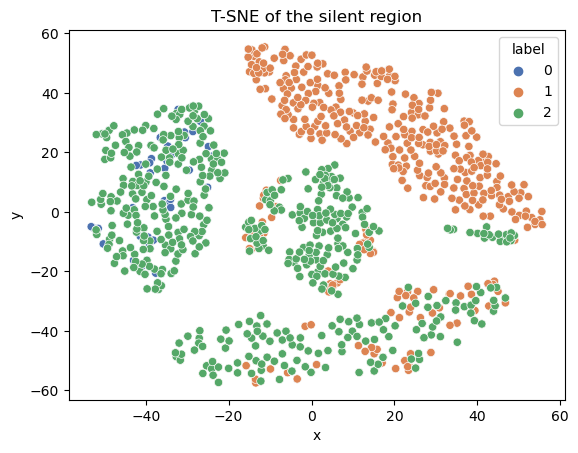

In [275]:
import seaborn as sns
sns.scatterplot(data=tsne_df, x="x", y="y", hue="label", palette="deep")
plt.title("T-SNE of the silent region")

The t-Sne shows four regions of points. However, they do not belong to the pre-defined drift labels. Therefore I will continue with the data above (from LuCa vs. NSR) and define own drift classes.